In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note_id,person_id,age,gender_source_value,BMI,admission_department,division,ward,asa_class,surgeon_id,...,condition_source_value,surgery_room,previous_surgery,emergency_status,op_timing,day_of_the_week,week_of_the_month,month,surgeon_estimated_op_time,surgery_duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
# Correcting the column to 'surgical_department'
adult_depts_corrected = df[~df['surgical_department'].str.startswith('Pediatric')]
pediatric_depts_corrected = df[df['surgical_department'].str.startswith('Pediatric')]

# Counting the number of df entries for each category in the corrected column
adult_dept_count_corrected = adult_depts_corrected['surgical_department'].value_counts()
pediatric_dept_count_corrected = pediatric_depts_corrected['surgical_department'].value_counts()

adult_dept_count_corrected, pediatric_dept_count_corrected

(surgical_department
 General Surgery                    36466
 Ophthalmology                      17437
 Orthopedics                        16617
 Urology                            12741
 Otolaryngology                     11772
 Obstetrics & Gynecology            11510
 Cardiovascular Thoracic Surgery     9341
 Plastic Surgery                     8460
 Neurosurgery                        7187
 Name: count, dtype: int64,
 surgical_department
 Pediatric Ophthalmology       7857
 Pediatric Otolaryngology      5764
 Pediatric Surgery             4021
 Pediatric Orthopedics         3905
 Pediatric Urology             2975
 Pediatric Plastic Surgery     2124
 Pediatric Thoracic Surgery    1876
 Pediatric Neurosurgery        1166
 Name: count, dtype: int64)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 특정 컬럼의 분리 및 제거:
# 먼저 note_id, person_id, surgeon_estimated_op_time, final_op_name 컬럼을 데이터셋에서 제거합니다. 
# 이 컬럼들은 모델링에 필요하지 않거나 예측에 도움이 되지 않는 정보를 포함할 수 있습니다.
# Specific columns separation and removal
note_id = df['note_id']
person_id = df['person_id']
surgeon_estimated_op_time = df['surgeon_estimated_op_time']
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# 범주형 데이터 인코딩:
# 범주형 데이터를 숫자로 변환하기 위해 인코딩을 수행합니다.
# 이진 인코딩(Binary Encoding), 원-핫 인코딩(One-Hot Encoding)
# Encoding categorical data
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# 데이터 분할:
# X_all: 모델링에 사용할 모든 특성(features)을 포함합니다. surgery_duration을 제외한 모든 컬럼을 포함합니다.
# y_all: 예측하고자 하는 목표 변수(target variable), 즉 surgery_duration입니다.
# train_test_split: 데이터셋을 훈련 세트와 테스트 세트로 분할합니다. 일반적으로 80%의 데이터를 훈련에, 나머지 20%는 모델 성능 평가에 사용합니다. random_state=42를 설정하여 분할이 재현 가능하도록 합니다.
# Data splitting
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all.head(), y_train_all.head()


(        age        BMI  admission_department  ward  surgeon_id  op_code  \
 61344    60  19.477567                     8    64          34     2867   
 137241    3  19.953791                    23    29          19     1869   
 139478   57  22.486020                    12    26         123      471   
 113549    9  13.982958                    25    53          22     2553   
 149411   30  19.604579                    17     1          20     2699   
 
         condition_source_value  surgery_room  \
 61344                      501            15   
 137241                    3971            31   
 139478                    2449            34   
 113549                    2638            30   
 149411                    2206            26   
 
         surgical_department_Cardiovascular Thoracic Surgery  \
 61344                                               False     
 137241                                              False     
 139478                                              F

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


Mean difference: -0.7352127527602035, Median difference: -2.1200000000000045, Std. deviation of difference: 31.654347287245944


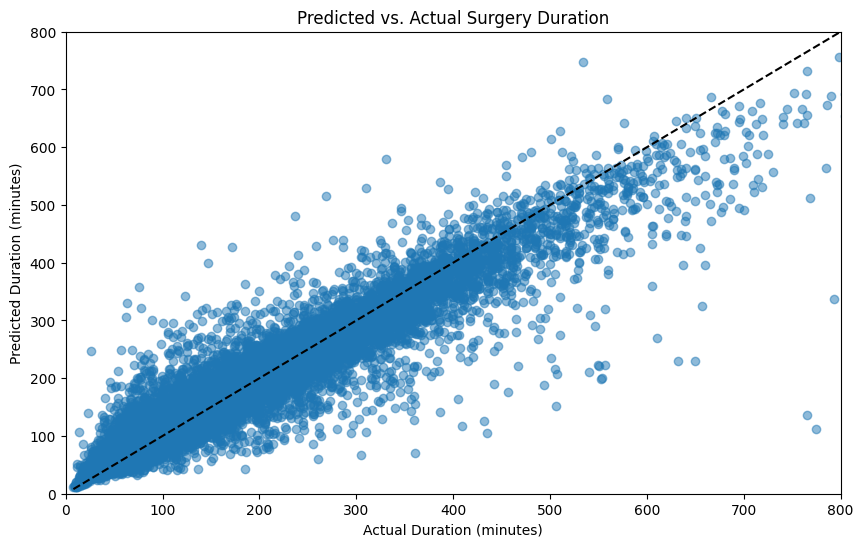

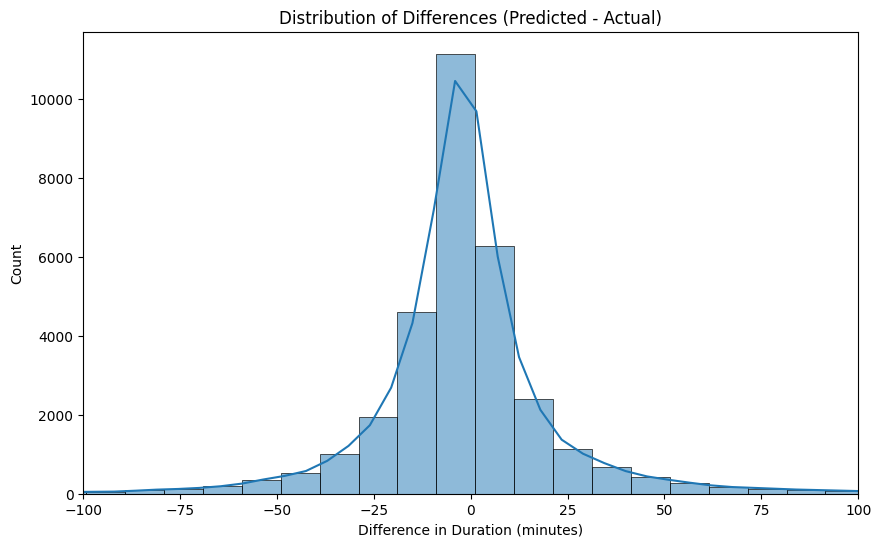

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_predictions' is the array of predicted durations from the model
# and 'y_test_all' is the actual surgery durations from the test set

# 1. Comparing Predictions with Actual Values
differences = y_test_all - final_predictions

# 2. Statistical Analysis
mean_diff = differences.mean()
median_diff = differences.median()
std_diff = differences.std()
print(f"Mean difference: {mean_diff}, Median difference: {median_diff}, Std. deviation of difference: {std_diff}")

# 3. Visualization

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_all, final_predictions, alpha=0.5)
plt.xlim(0, 800)  # Limiting the x-axis range
plt.ylim(0, 800)  # Limiting the x-axis range
plt.title('Predicted vs. Actual Surgery Duration')
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'k--')  # Diagonal line
plt.show()

# Histogram of Differences
plt.figure(figsize=(10, 6))
sns.histplot(differences, kde=True, binwidth=10)
plt.xlim(-100, 100)  # Limiting the x-axis range
plt.title('Distribution of Differences (Predicted - Actual)')
plt.xlabel('Difference in Duration (minutes)')
plt.show()


In [17]:
# Assuming 'department_errors' is a DataFrame with columns 'department', 'mean_error', and 'std_error'
plt.figure(figsize=(10, 6))
plt.errorbar(department_errors['department'], department_errors['mean_error'], yerr=department_errors['std_error'], fmt='o')
plt.title('Error Bar Plot by Department')
plt.xlabel('Department')
plt.ylabel('Mean Prediction Error (minutes)')
plt.xticks(rotation=45)
plt.show()


NameError: name 'department_errors' is not defined

<Figure size 1000x600 with 0 Axes>

In [18]:
# Training a general model on the entire dataset
general_model = RandomForestRegressor(n_estimators=100, random_state=42)
general_model.fit(X_train_all, y_train_all)

# Generating predictions for the test set
general_predictions = general_model.predict(X_test_all)

# Calculating differences for the general model
general_differences = y_test_all - general_predictions


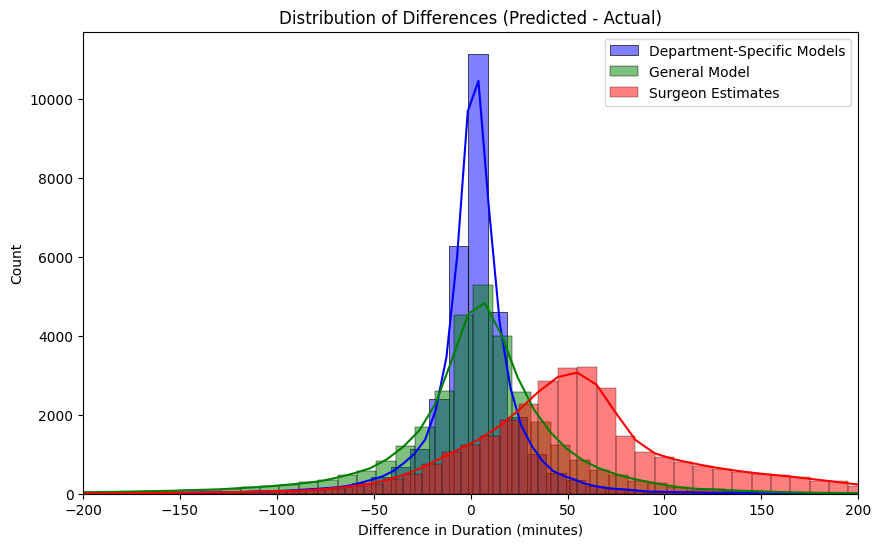

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


# Histogram of Differences
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions - y_test_all, kde=True, color="blue", label='Department-Specific Models', binwidth=10)
sns.histplot(general_predictions - y_test_all, kde=True, color="green", label='General Model', binwidth=10)
sns.histplot(surgeon_estimated_op_time - y_test_all, kde=True, color="red", label='Surgeon Estimates', binwidth=10)
plt.xlim(-200, 200)
plt.title('Distribution of Differences (Predicted - Actual)')
plt.xlabel('Difference in Duration (minutes)')
plt.legend()
plt.show()


In [22]:
import pandas as pd

# Calculating key statistics
stats_department_specific = {
    'mean': (final_predictions - y_test_all).mean(),
    'median': (final_predictions - y_test_all).median(),
    'std_dev': (final_predictions - y_test_all).std()
}

stats_general_model = {
    'mean': (general_predictions - y_test_all).mean(),
    'median': (general_predictions - y_test_all).median(),
    'std_dev': (general_predictions - y_test_all).std()
}

stats_surgeon_estimates = {
    'mean': (surgeon_estimated_op_time - y_test_all).mean(),
    'median': (surgeon_estimated_op_time - y_test_all).median(),
    'std_dev': (surgeon_estimated_op_time - y_test_all).std()
}

# Creating a DataFrame for the summary table
comparison_table = pd.DataFrame({
    'Department-Specific Models': stats_department_specific,
    'General Model': stats_general_model,
    'Surgeon Estimates': stats_surgeon_estimates
})

# Displaying the table
comparison_table

,Department-Specific Models,General Model,Surgeon Estimates
mean,0.735213,1.625797,60.407549
median,2.120000,5.210000,53.000000
std_dev,31.654347,57.429487,71.989622
